## MSstatsTMT Analysis：Proteomics differential expression downstream analysis

#### The following Jupyter notebooks allows to perform differential expression data analysis from multiple pipelines developed by the bigbio team. The output of the following pipelines are supported: 

- [proteomicsTMT](https://github.com/bigbio/proteomicstmt): TMT pipeline based on OpenMS and nextflow.

For the data with isobaric labeling, using the [MSstatsTMT](https://www.bioconductor.org/packages/release/bioc/html/MSstatsTMT.html) to perform the downstream data analysis. Major steps in the data processing are the following:

- Importing data from the pipeline. The major source of data are:
  - out.mzTab
  - metadata.sdrf.tsv or experimental_design.tsv 

### Convert out.mzTab to MSstatsTMT report from OpenMS

In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
%%R -w 800 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
data_folder = '../datasets/PXD009553'
openms_output = './out_msstats.csv'
setwd(data_folder)
raw.om <- read.csv(openms_output, header = TRUE, sep = ',')
input.om <- OpenMStoMSstatsTMTFormat(raw.om)
head(input.om)

INFO  [2021-09-12 09:06:07] ** Raw data from OpenMS imported successfully.
INFO  [2021-09-12 09:06:08] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-09-12 09:06:08] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-09-12 09:06:08] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-09-12 09:06:08] ** Shared peptides are removed.
INFO  [2021-09-12 09:06:08] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-09-12 09:06:25] ** PSMs have been aggregated to peptide ions.
INFO  [2021-09-12 09:06:25] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-09-12 09:06:25] ** Fractionation handled.
INFO  [2021-

### Protein summarization, normalization and visualization

INFO  [2021-09-12 09:12:35] ** MSstatsTMT - proteinSummarization function
INFO  [2021-09-12 09:12:35] Summarizing for Run : 1_2_1 ( 1  of  12 )
  |======================================================================| 100%
INFO  [2021-09-12 09:12:43] Summarizing for Run : 3_8_1 ( 2  of  12 )
  |======================================================================| 100%
INFO  [2021-09-12 09:12:51] Summarizing for Run : 3_9_1 ( 3  of  12 )
  |======================================================================| 100%
INFO  [2021-09-12 09:12:59] Summarizing for Run : 1_1_1 ( 4  of  12 )
  |======================================================================| 100%
INFO  [2021-09-12 09:13:07] Summarizing for Run : 1_3_1 ( 5  of  12 )
  |======================================================================| 100%
INFO  [2021-09-12 09:13:16] Summarizing for Run : 2_4_1 ( 6  of  12 )
  |======================================================================| 100%
INFO  [2021-09-12 09:13:22

R[write to console]: Drew the Profile plot for 1 proteins.



  |======================================================================| 100%


R[write to console]: Drew the Profile plot with summarization for 1 proteins.



  |======================================================================| 100%


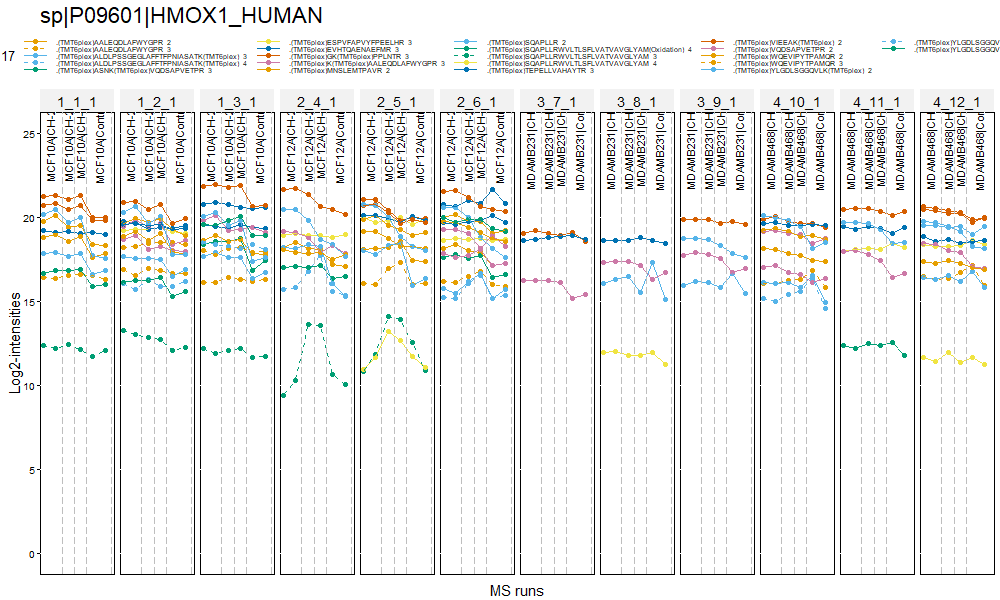

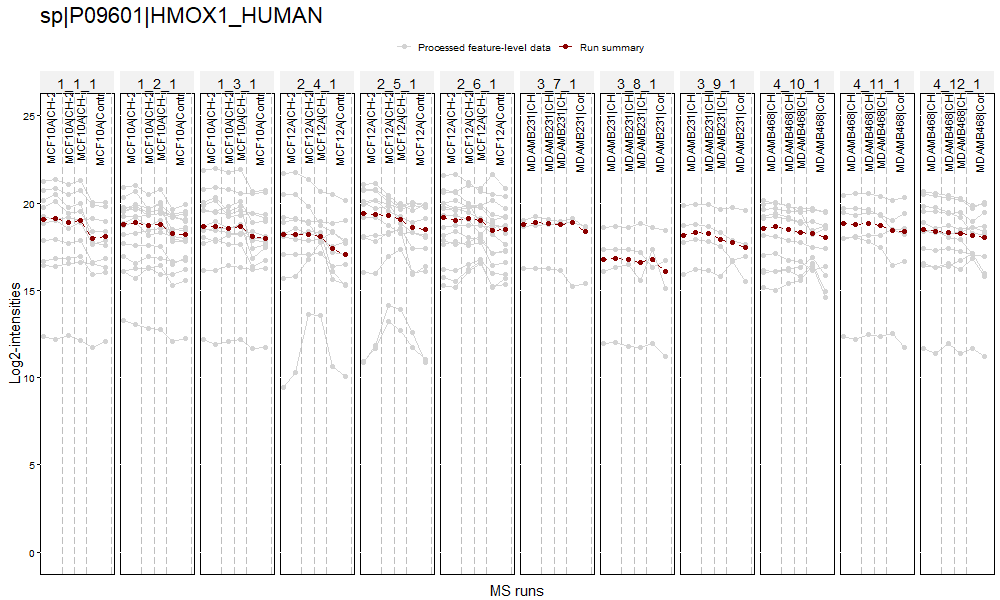

In [4]:
%%R -w 1000 -h 1000

protein_expression = './protein_expression.csv'

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=TRUE,
                                      remove_norm_channel = TRUE,
                                      remove_empty_channel = TRUE)

## Profile plot without norm channnels and empty channels
dataProcessPlotsTMT(data=quant_om.msstats,
                     type = 'ProfilePlot',
                     which.Protein = 'sp|P09601|HMOX1_HUMAN',
                     width = 21, # adjust the figure width 
                     height = 7,
                     address=FALSE)
TMTProtein.Expression <- quant_om.msstats$ProteinLevelData[, c('Protein', 'Abundance', 'Condition')]

write.csv(TMTProtein.Expression, file=protein_expression, row.names=FALSE)

R[write to console]: Drew the Quality Contol plot(boxplot) over all proteins.



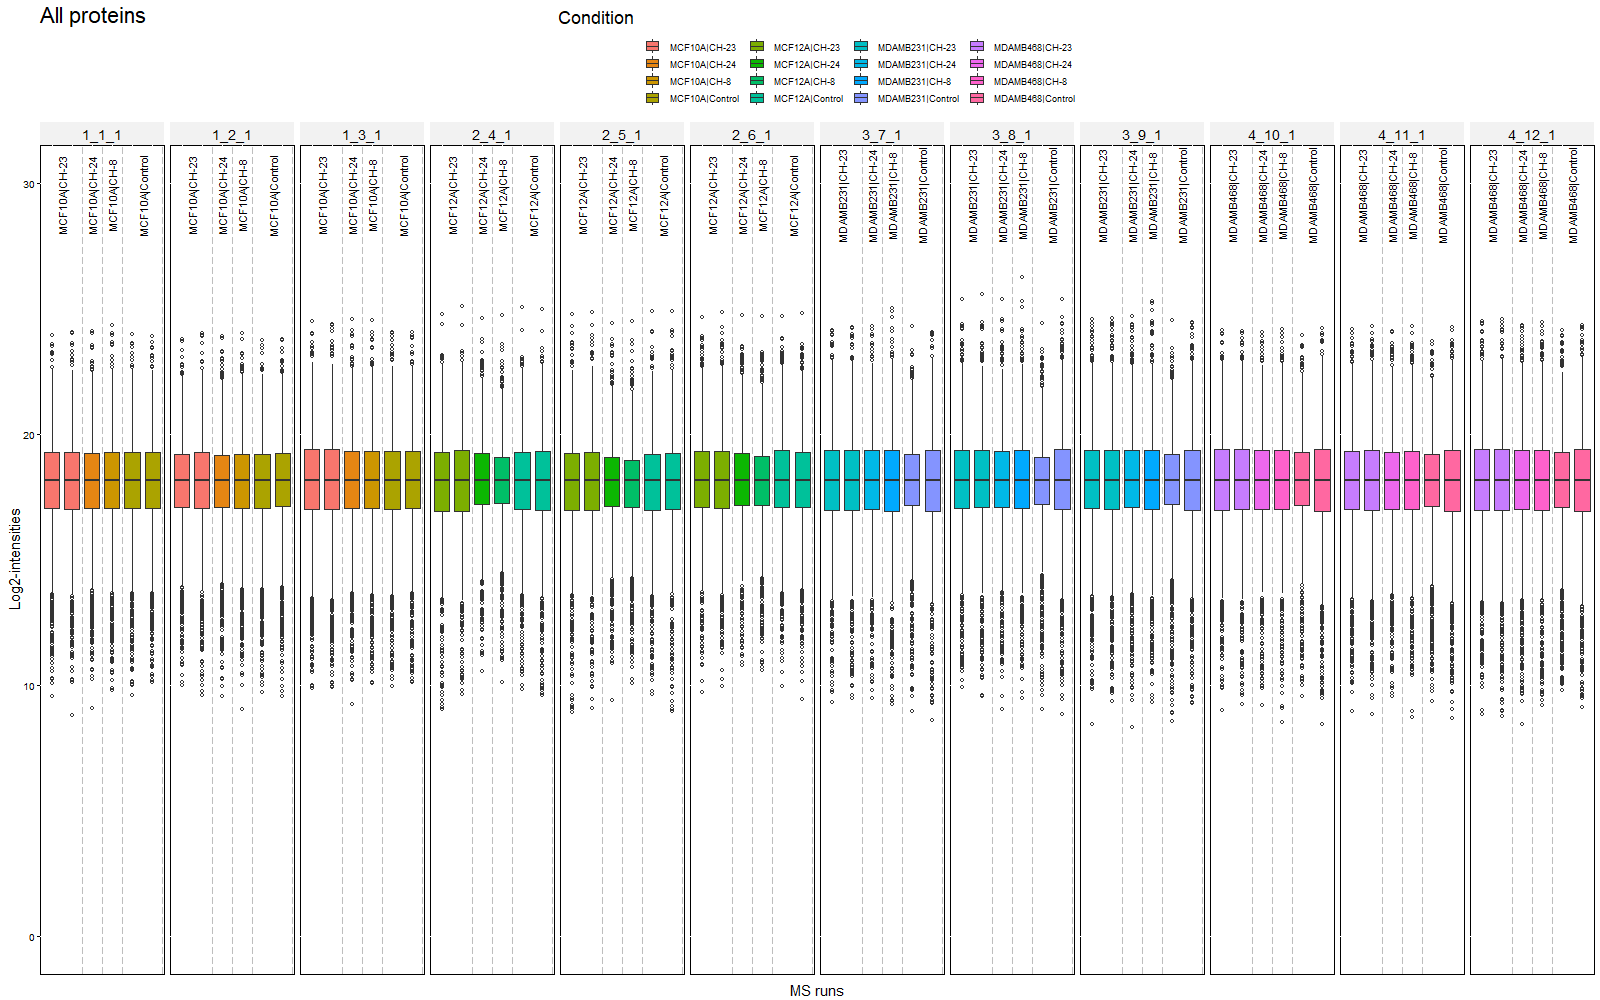

In [8]:
%%R -w 1600 -h 1000

tmp <- levels(input.om$ProteinName)
selector <- append('allonly', tmp, 1)
## Quality control plot 
dataProcessPlotsTMT(data=quant_om.msstats, 
                     type='QCPlot',
                     which.Protein=selector,
                     width = 21, # adjust the figure width
                     height = 12,
                     address = FALSE)

### Tests for significant changes in protein abundance across conditions

In [9]:
%%R
# Check the conditions in the protein level data
levels(quant_om.msstats$ProteinLevelData$Condition)

 [1] "MCF10A|CH-23"     "MCF10A|CH-24"     "MCF10A|CH-8"      "MCF10A|Control"  
 [5] "MCF12A|CH-23"     "MCF12A|CH-24"     "MCF12A|CH-8"      "MCF12A|Control"  
 [9] "MDAMB231|CH-23"   "MDAMB231|CH-24"   "MDAMB231|CH-8"    "MDAMB231|Control"
[13] "MDAMB468|CH-23"   "MDAMB468|CH-24"   "MDAMB468|CH-8"    "MDAMB468|Control"


In [10]:
%%R -w 1000 -h 600

MCF10A_Comp<-matrix(c(1,0,0,0,1,0,0,0,1,-1,-1,-1,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0),nrow=3)
row.names(MCF10A_Comp)<-c("MCF10A|CH-23 vs MCF10A|Control", "MCF10A|CH-24 vs MCF10A|Control", "MCF10A|CH-8 vs MCF10A|Control")
colnames(MCF10A_Comp) = c("MCF10A|CH-23","MCF10A|CH-24","MCF10A|CH-8","MCF10A|Control",
                        "MCF12A|CH-23","MCF12A|CH-24","MCF12A|CH-8","MCF12A|Control",
                        "MDAMB231|CH-23","MDAMB231|CH-24","MDAMB231|CH-8","MDAMB231|Control",
                        "MDAMB468|CH-23","MDAMB468|CH-24","MDAMB468|CH-8","MDAMB468|Control")


MCF10A.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix =MCF10A_Comp, moderated = TRUE)

INFO  [2021-09-12 09:18:48] Model fitting for 2116 proteins.
  |======================================================================| 100%
INFO  [2021-09-12 09:21:18] Testing for 2116 proteins:
  |======================================================================| 100%


In [11]:
%%R

head(MCF10A.pairwise$ComparisonResult)

                   Protein                          Label       log2FC
1:    sp|A0AVT1|UBA6_HUMAN MCF10A|CH-23 vs MCF10A|Control  0.006299893
2:    sp|A0AVT1|UBA6_HUMAN MCF10A|CH-24 vs MCF10A|Control -0.033531291
3:    sp|A0AVT1|UBA6_HUMAN  MCF10A|CH-8 vs MCF10A|Control -0.161207712
4: sp|A0FGR8-2|ESYT2_HUMAN MCF10A|CH-23 vs MCF10A|Control  0.342381972
5: sp|A0FGR8-2|ESYT2_HUMAN MCF10A|CH-24 vs MCF10A|Control  0.450249874
6: sp|A0FGR8-2|ESYT2_HUMAN  MCF10A|CH-8 vs MCF10A|Control  0.599977979
          SE        DF      pvalue adj.pvalue issue
1: 0.0975285  6.810509 0.950351136  0.9996744  <NA>
2: 0.1194475  6.810509 0.787261073  0.9980902  <NA>
3: 0.1194475  6.810509 0.220277608  0.9995924  <NA>
4: 0.1371491 16.810512 0.023247407  0.9996744  <NA>
5: 0.1679727 16.810512 0.015914377  0.7548016  <NA>
6: 0.1679727 16.810512 0.002382984  0.5611927  <NA>


#### Visualization MCF10A Cell line Condtion

In [12]:
%%R

MCF10A = MCF10A.pairwise$ComparisonResult
write.table(MCF10A,"MCF10A_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

                   Protein                           Label    log2FC  \
0     sp|A0AVT1|UBA6_HUMAN  MCF10A|CH-23 vs MCF10A|Control  0.006300   
1     sp|A0AVT1|UBA6_HUMAN  MCF10A|CH-24 vs MCF10A|Control -0.033531   
2     sp|A0AVT1|UBA6_HUMAN   MCF10A|CH-8 vs MCF10A|Control -0.161208   
3  sp|A0FGR8-2|ESYT2_HUMAN  MCF10A|CH-23 vs MCF10A|Control  0.342382   
4  sp|A0FGR8-2|ESYT2_HUMAN  MCF10A|CH-24 vs MCF10A|Control  0.450250   

     pvalue  -Log10(p-value)    group  
0  0.950351         0.022116  dimgrey  
1  0.787261         0.103881  dimgrey  
2  0.220278         0.657030  dimgrey  
3  0.023247         1.633625  tab:red  
4  0.015914         1.798210  tab:red  


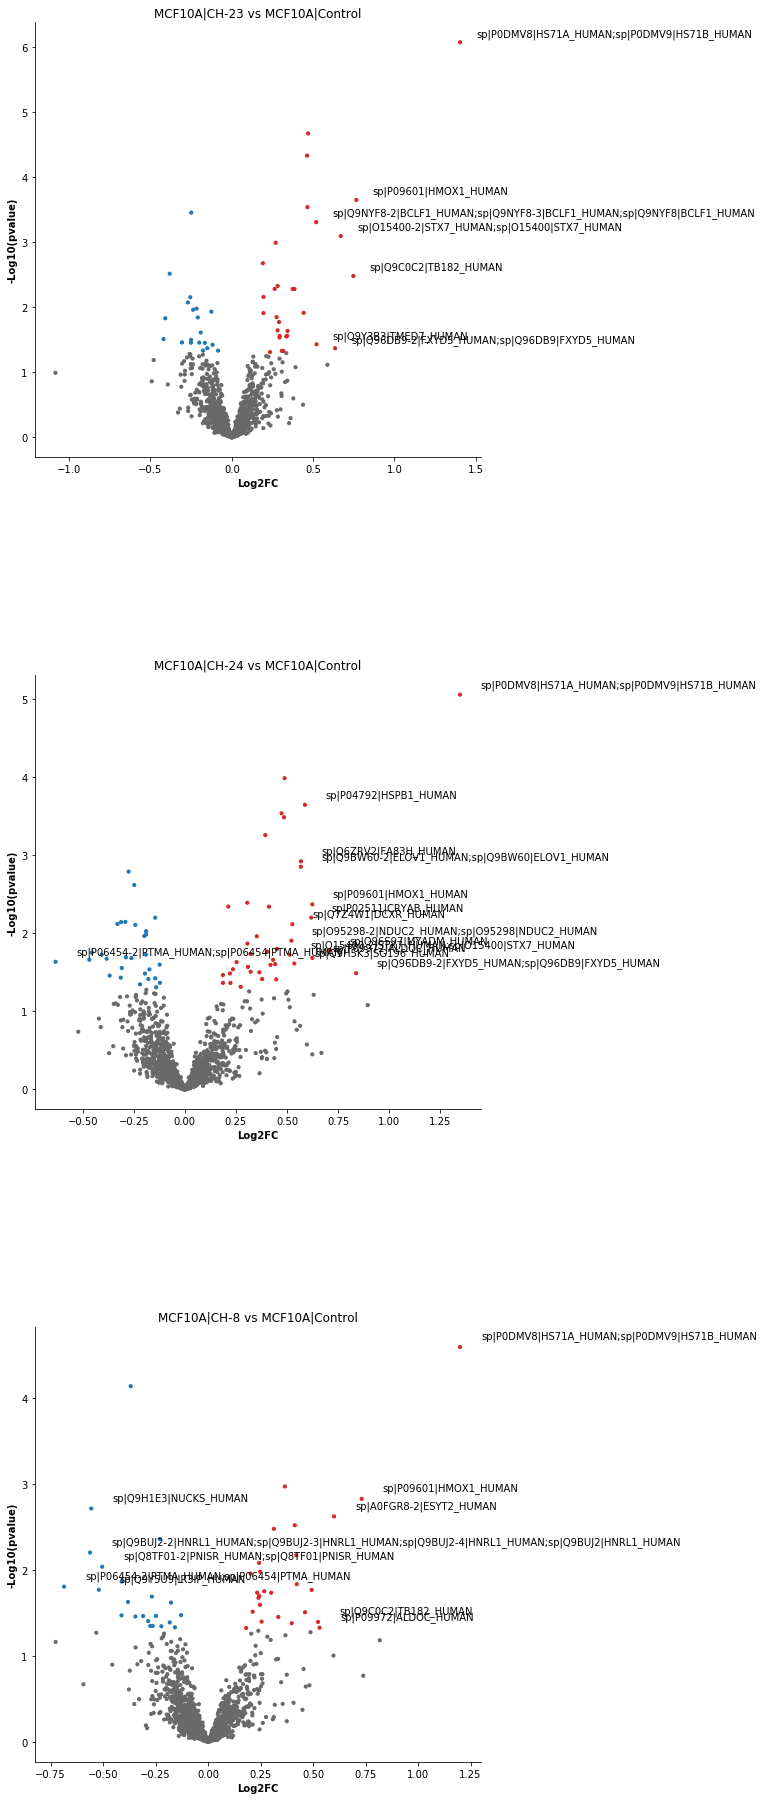

In [17]:
import pandas as pd
import seaborn as sns
import numpy as np 
from matplotlib import pyplot as plt

result = pd.read_csv('./MCF10A_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#分组为up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 0)&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < 0)&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())

xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(8, 32))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(310 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(-2,10,3)) 
    ax.set_title(comp)
    i += 1
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 0.5)].iterrows():
        ax.annotate(row['Protein'], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

### compare with article given 
#### The total protein given in the article and our MCF10 total protein intersection is 743. We can quantified more proteins (624). Because the article does not give the threshold of FC, the total difference protein of the article cannot be obtained . Among them, the top 20 differential expressed protein intersection in the case of MCF10A CH-1 is 7

In [19]:
# map protein to gene name
import re
import urllib.parse
import urllib.request

def MapProtGeneName(prots):
    url = 'https://www.uniprot.org/uploadlists/'
    query = ' '.join(prots)
    params = {
    'from': 'ACC+ID',
    'to': 'GENENAME',
    'format': 'tab',
    'query':query
    }

    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
        response = f.read()
        data = response.decode('utf-8')
        r = {}
        keys = re.split('\t|\n', data)[::2][1:-1]
        values = re.split('\t|\n', data)[1::2][1:]
        for i in range(len(keys)):
            if keys[i] in r:
                r[keys[i]] = r[keys[i]] + "/" + values[i]
            else:
                r[keys[i]] = values[i]     
    return r


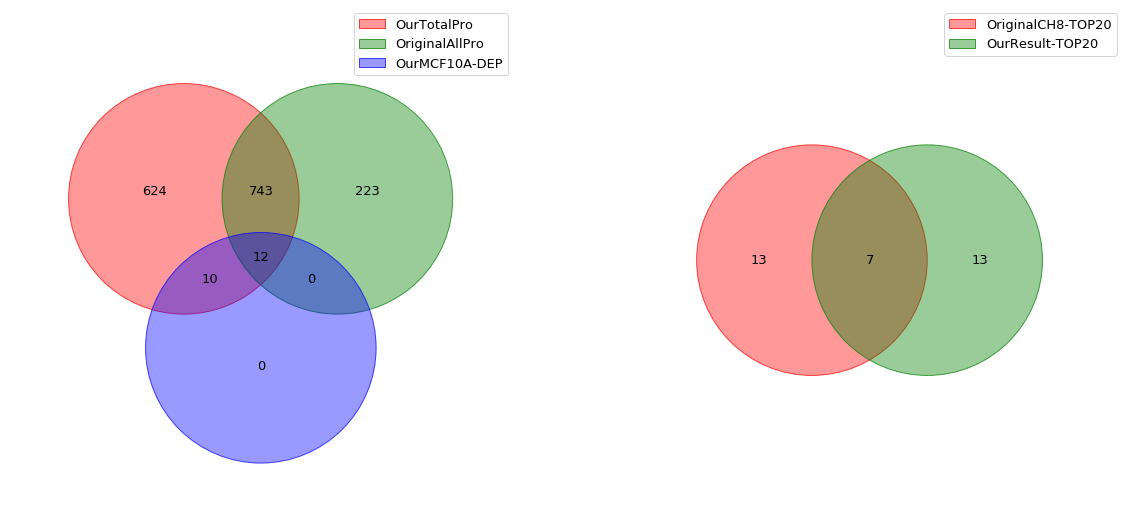

In [31]:
from venn import venn
import pandas as pd
from matplotlib import pyplot as plt

# TOP ten protein per condition comparison
# 1. MCF10A  CH-23=CH-2  CH-8=CH-1  CH-24=CH-3
result = pd.read_csv('./MCF10A_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()

MCF10A_All = list(set(result['Protein']))

MCF10A_DEP = result[((result['log2FC'] > 0.5)&(result['pvalue'] < 0.05)) | ((result['log2FC'] < -0.5)&(result['pvalue'] < 0.05))]

CH8_all = result[result['Label'] == 'MCF10A|CH-8 vs MCF10A|Control']
CH8_all = CH8_all[CH8_all['pvalue'] < 0.05]

CH8_all = CH8_all.reindex(CH8_all['log2FC'].abs().sort_values(ascending=False).index)[:20]

# read data of the article
article_result = pd.read_excel("./Perseus results.xlsx", header=0, sheet_name="MCF10A")
# p1 = article_result[(article_result["Log2(CH-1/Control)"] > 0.606) | (article_result["Log2(CH-1/Control)"] < -0.606)]['Gene names'].tolist()

p1 = article_result['Gene names'].tolist()
article_top_20 = article_result.reindex(article_result['Log2(CH-1/Control)'].abs().sort_values(ascending=False).index)[:20]['Gene names']

def preprocess(pro):
    return pro.split('|')[-1]
    
MCF10A_All = MapProtGeneName(list(map(preprocess, MCF10A_All))).values()


our_result = MapProtGeneName(list(map(preprocess, CH8_all['Protein'].tolist()))).values()

                             
MCF10A_All_DEP = MapProtGeneName(list(map(preprocess, MCF10A_DEP['Protein'].tolist()))).values()

_, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
venn({'OurTotalPro': set(MCF10A_All), 'OriginalAllPro': set(p1), 'OurMCF10A-DEP': set(MCF10A_All_DEP)}, cmap=['r', 'g', 'b'], figsize=(10, 10), ax=axs[0])

venn({'OriginalCH8-TOP20': set(article_top_20), 'OurResult-TOP20': set(our_result)}, cmap=['r', 'g'], figsize=(10, 10), ax=axs[1])

#### the top 20 difference protein intersection in the case of MCF10A CH-2 is 6

                                                Protein  \
1224        sp|P0DMV8|HS71A_HUMAN;sp|P0DMV9|HS71B_HUMAN   
5751      sp|Q9NX61-2|T161A_HUMAN;sp|Q9NX61|T161A_HUMAN   
1191                              sp|P09601|HMOX1_HUMAN   
5427                              sp|Q9C0C2|TB182_HUMAN   
243         sp|O15400-2|STX7_HUMAN;sp|O15400|STX7_HUMAN   
4986      sp|Q96DB9-2|FXYD5_HUMAN;sp|Q96DB9|FXYD5_HUMAN   
3963                              sp|Q14657|LAGE3_HUMAN   
6171                              sp|Q9Y3B3|TMED7_HUMAN   
5766  sp|Q9NYF8-2|BCLF1_HUMAN;sp|Q9NYF8-3|BCLF1_HUMA...   
5586      sp|Q9HCD6-2|TANC2_HUMAN;sp|Q9HCD6|TANC2_HUMAN   
903                                sp|P04731|MT1A_HUMAN   
723                                sp|O95817|BAG3_HUMAN   
909                               sp|P04792|HSPB1_HUMAN   
3786                              sp|Q13501|SQSTM_HUMAN   
813                               sp|P02511|CRYAB_HUMAN   
6345                              sp|Q9Y6X1|SERP1_HUMAN 

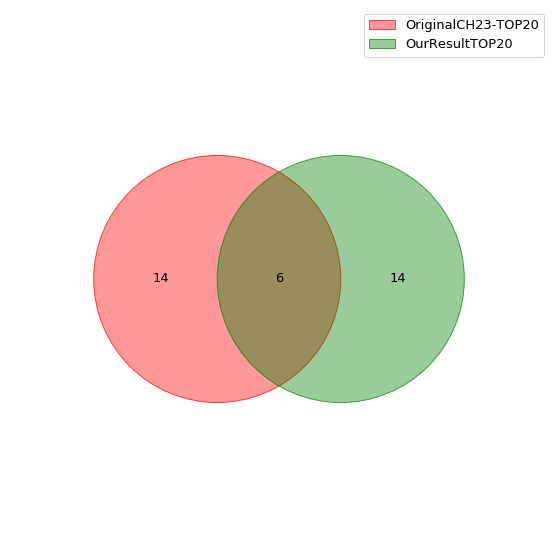

In [34]:
# Note： Protein Group is not pre-preprocessed

# MCF10A  CH-23=CH-2
CH23_all = result[result['Label'] == 'MCF10A|CH-23 vs MCF10A|Control']
CH23_all[CH23_all['pvalue'] < 0.05]

CH23_all = CH23_all.reindex(CH23_all['log2FC'].abs().sort_values(ascending=False).index)[:20]
print(CH23_all)

# read data of the article
article_result = pd.read_excel("./Perseus results.xlsx", header=0, sheet_name="MCF10A")
# p1 = article_result[(article_result["Log2(CH-1/Control)"] > 0.606) | (article_result["Log2(CH-1/Control)"] < -0.606)]['Gene names'].tolist()
p1 = article_result['Gene names'].tolist()
article_top_20 = article_result.reindex(article_result['Log2(CH-2/Control)'].abs().sort_values(ascending=False).index)[:20]['Gene names']

def preprocess(s):
    return s.split('|')[-1]

our_result = MapProtGeneName(list(map(preprocess, CH23_all['Protein'].tolist()))).values()
print(our_result)

venn({'OriginalCH23-TOP20': set(article_top_20), 'OurResultTOP20': set(our_result)}, cmap=['r', 'g'], figsize=(10, 10))

#### the top 20 difference protein intersection in the case of MCF10A CH-2 is 6

dict_values(['HSPA1B', 'HSPA2', 'FXYD5', 'MYADM', 'PON2', 'PTMA', 'TAP1', 'ALDOC', 'HMOX1', 'SEC61G', 'CRYAB', 'SERP1', 'HSPB1', 'FAM83H', 'ELOVL1', 'SPRR1B', 'ATP6V0C', 'BCAP31', 'POMK', 'DCXR'])


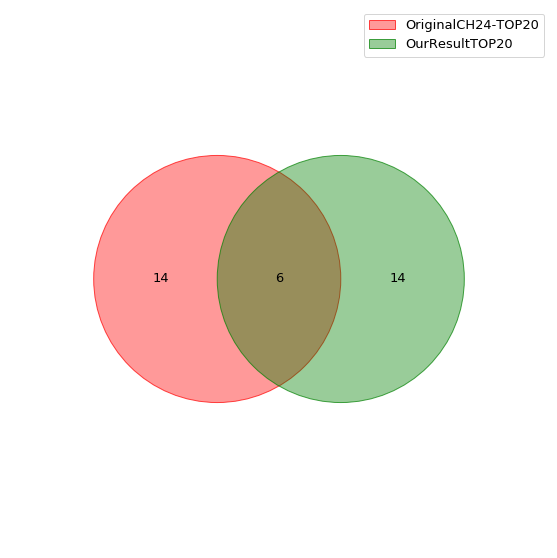

In [36]:
# MCF10A  CH-24=CH-3
CH24_all = result[result['Label'] == 'MCF10A|CH-24 vs MCF10A|Control']

CH24_all[CH24_all['pvalue'] < 0.05]

CH24_all = CH24_all.reindex(CH24_all['log2FC'].abs().sort_values(ascending=False).index)[:20]

# read data of the article
article_result = pd.read_excel("./Perseus results.xlsx", header=0, sheet_name="MCF10A", )
# p1 = article_result[(article_result["Log2(CH-1/Control)"] > 0.606) | (article_result["Log2(CH-1/Control)"] < -0.606)]['Gene names'].tolist()

p1 = article_result['Gene names'].tolist()
article_top_20 = article_result.reindex(article_result['Log2(CH-3/Control)'].abs().sort_values(ascending=False).index)[:20]['Gene names']

def preprocess(s):
    return s.split('|')[-1]

our_result = MapProtGeneName(list(map(preprocess, CH24_all['Protein'].tolist()))).values()
print(our_result)

venn({'OriginalCH24-TOP20': set(article_top_20), 'OurResultTOP20': set(our_result)}, cmap=['r', 'g'], figsize=(10, 10))

###  Protein expression Heatmaps

#### report: From the expression heat map, in line with the results of the article, the expressions of non-cancer cell lines MCF10A and MCF12A are similar. Cancer cell lines MDA-MB-231 and MDA-MB-468 have similar expressions

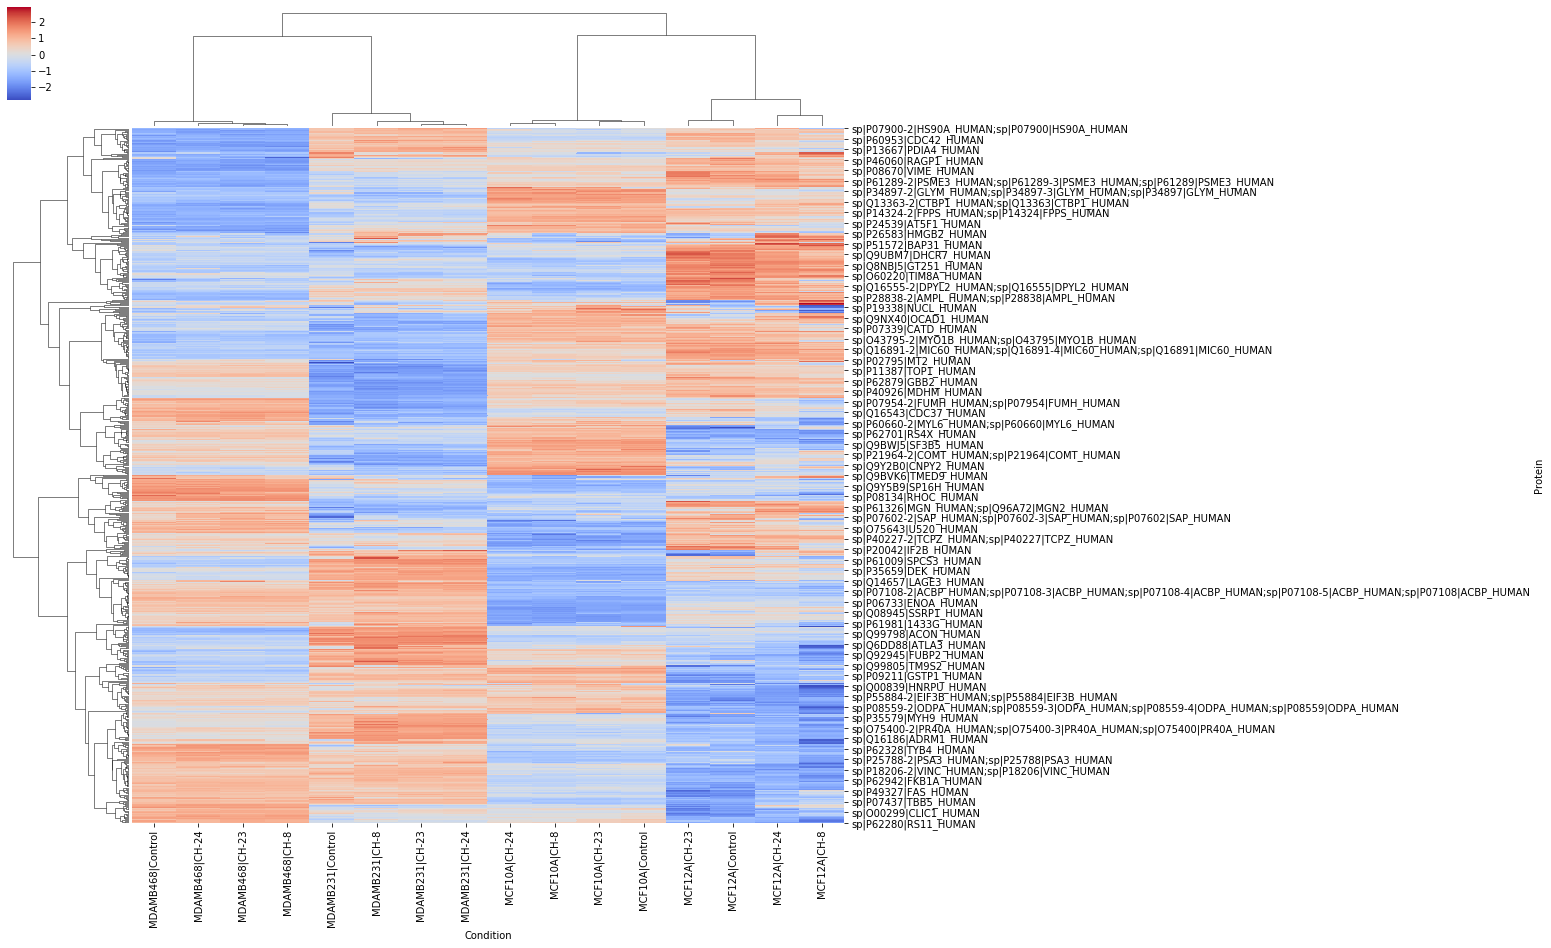

In [39]:
# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
 
# Data set
url = './protein_expression.csv'
df = pd.read_csv(url)

df2 = df.pivot_table(index='Protein', columns='Condition', values='Abundance',aggfunc=np.mean)
df2 = df2.dropna()

# plot
g = sns.clustermap(df2, method='average', metric='correlation', z_score=0, figsize=(15,15), xticklabels=True, cmap="coolwarm")
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels())#, fontsize = 5)

# tmp = g.ax_heatmap.get_xaxis()

threshold = 0.1
x_labels_ticks = g.ax_heatmap.get_xticklabels()

total_genes_above_threshold = 0
for i, xtickdata in enumerate(x_labels_ticks):
    protein = xtickdata._text
    if df2[protein].max() >= threshold:
        # print(df2[protein])
        # print("#########")
        total_genes_above_threshold = total_genes_above_threshold + 1
        # print(df2[protein].max())
    else:
        xtickdata._text = ''

#print("total_genes_above_threshold {}".format(total_genes_above_threshold))

# re set the tick labels with the modified list
g.ax_heatmap.set_xticklabels(x_labels_ticks)
plt.show()

### Visualization MDAMB231 Cell line Condtion

In [47]:
%%R -w 1000 -h 600

MDAMB231_Comp<-matrix(c(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0, 1,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0),nrow=3)
row.names(MDAMB231_Comp)<-c("MDAMB231|CH-23 vs MDAMB231|Control", "MDAMB231|CH-24 vs MDAMB231|Control", "MDAMB231|CH-8 vs MDAMB231|Control")
colnames(MDAMB231_Comp) = c("MCF10A|CH-23","MCF10A|CH-24","MCF10A|CH-8","MCF10A|Control",
                        "MCF12A|CH-23","MCF12A|CH-24","MCF12A|CH-8","MCF12A|Control",
                        "MDAMB231|CH-23","MDAMB231|CH-24","MDAMB231|CH-8","MDAMB231|Control",
                        "MDAMB468|CH-23","MDAMB468|CH-24","MDAMB468|CH-8","MDAMB468|Control")
MDAMB231.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix =MDAMB231_Comp, moderated = TRUE)

write.table(MDAMB231.pairwise$ComparisonResult,"MDAMB231_result.csv",row.names=FALSE,col.names=TRUE,sep=",")


INFO  [2021-09-12 11:05:27] Model fitting for 2116 proteins.
  |======================================================================| 100%
INFO  [2021-09-12 11:07:46] Testing for 2116 proteins:
  |======================================================================| 100%


                                         Protein  \
0                           sp|A0AVT1|UBA6_HUMAN   
1                           sp|A0AVT1|UBA6_HUMAN   
2                           sp|A0AVT1|UBA6_HUMAN   
6  sp|A6NHL2-2|TBAL3_HUMAN;sp|A6NHL2|TBAL3_HUMAN   
7  sp|A6NHL2-2|TBAL3_HUMAN;sp|A6NHL2|TBAL3_HUMAN   

                                Label    log2FC    pvalue  -Log10(p-value)  \
0  MDAMB231|CH-23 vs MDAMB231|Control  0.084122  0.417728         0.379106   
1  MDAMB231|CH-24 vs MDAMB231|Control  0.037059  0.765647         0.115972   
2   MDAMB231|CH-8 vs MDAMB231|Control -0.059278  0.635317         0.197010   
6  MDAMB231|CH-23 vs MDAMB231|Control -0.378318  0.079360         1.100401   
7  MDAMB231|CH-24 vs MDAMB231|Control -0.427023  0.102876         0.987687   

     group  
0  dimgrey  
1  dimgrey  
2  dimgrey  
6  dimgrey  
7  dimgrey  


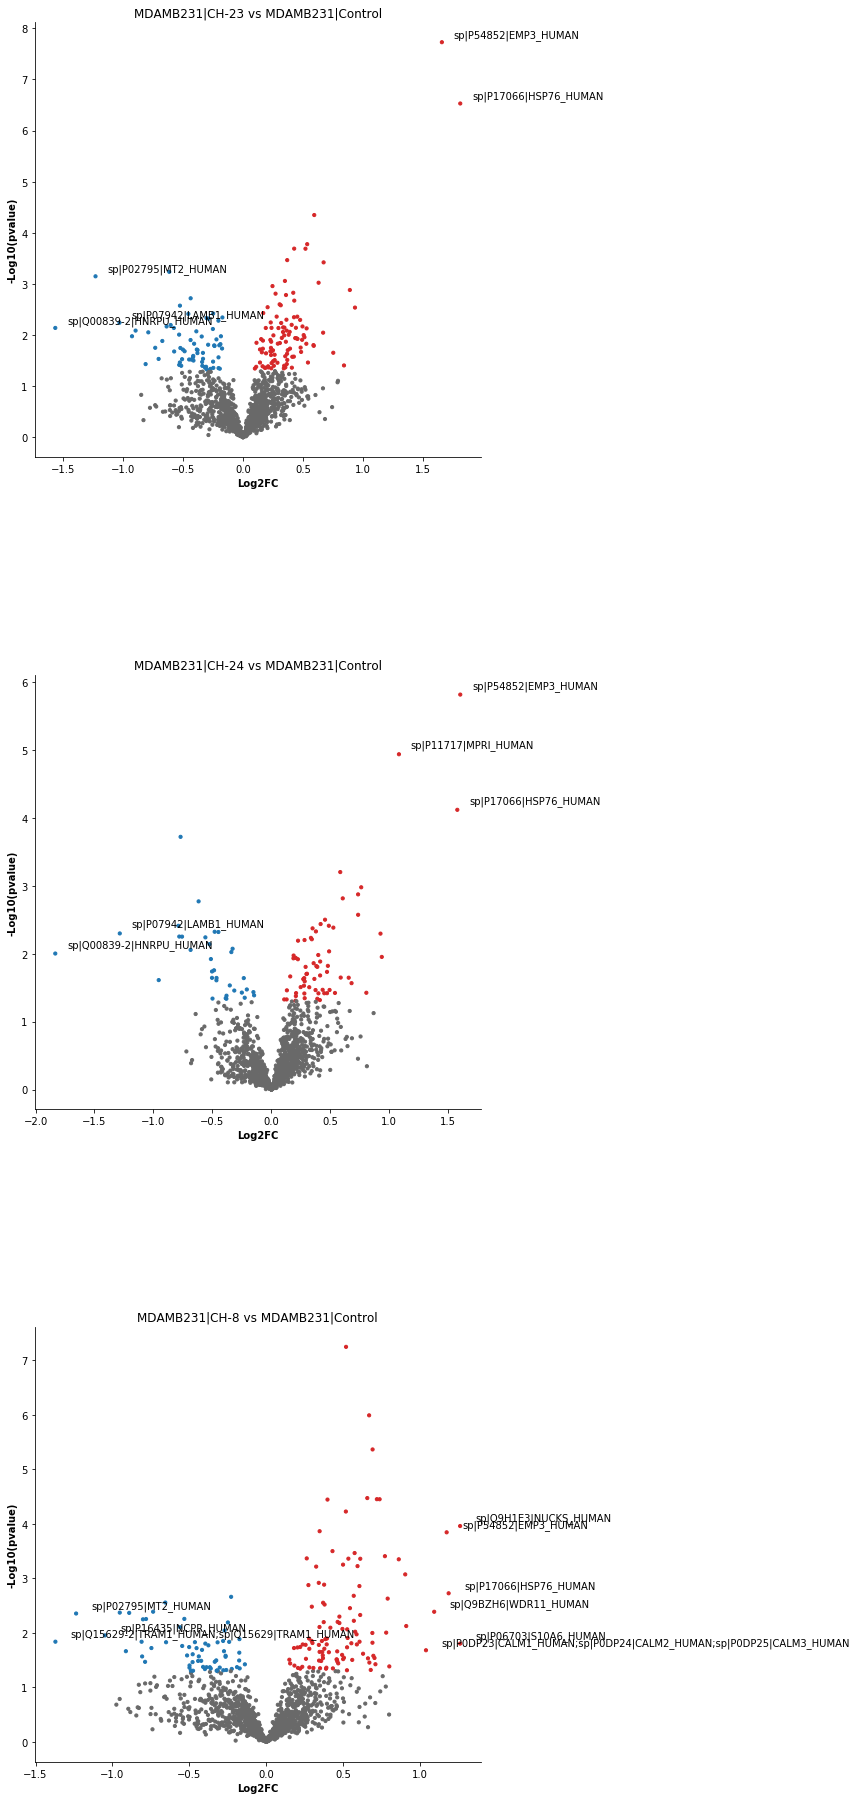

In [49]:
import pandas as pd
import seaborn as sns
import numpy as np 
from matplotlib import pyplot as plt

result = pd.read_csv('./MDAMB231_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#分组为up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 0)&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -0)&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())

xmin=-2
xmax=2
ymin=-2
ymax=20
fig = plt.figure(figsize=(8, 32))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(310 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
     
    ax.set_title(comp)
    i += 1
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 1)].iterrows():
        ax.annotate(row['Protein'], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

##### We quantified more proteins and the most proteins given in the article are in our result. But the shared top 20 differential expressed proteins only one. Protein groups that are not preprocessed is a reason

dict_values(['HSPA6', 'EMP3', 'HNRNPU', 'MT2A', 'LAMB1', 'WDR11', 'CCAR1', 'POR', 'ELOVL5', 'S100A6', 'COX20', 'DNAJC3', 'FXYD5', 'LPCAT1', 'GTF2I', 'IGF2R', 'KDELR1', 'HSD17B10', 'HSPA1B'])


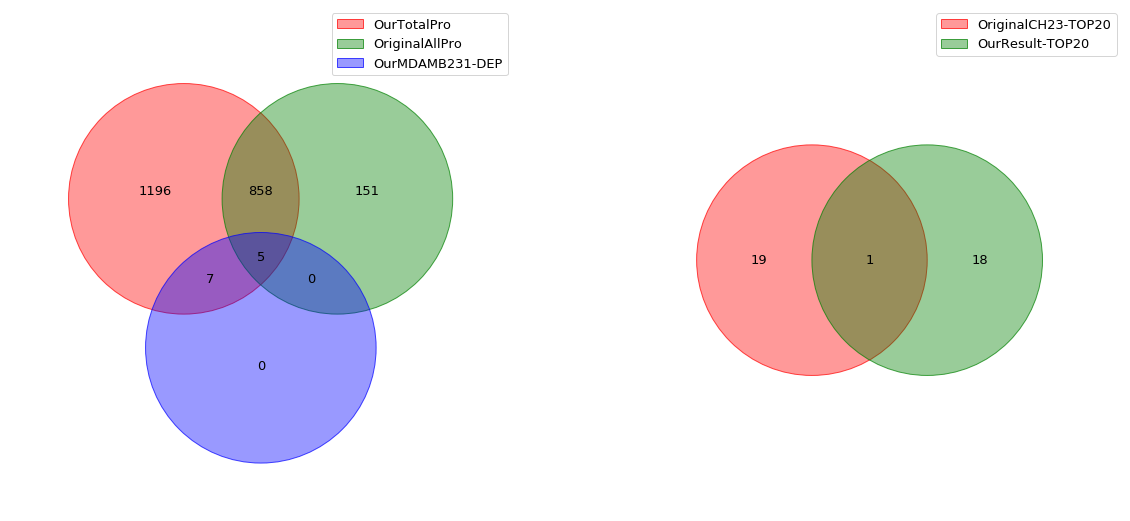

In [53]:
# TOP ten protein per condition comparison

result = pd.read_csv('./MDAMB231_result.csv', sep=',')

MDAMB231_All = result['Protein'].tolist()

MDAMB231_DEP = result[((result['log2FC'] > 1)&(result['pvalue'] < 0.05)) | ((result['log2FC'] < -1)&(result['pvalue'] < 0.05))]

CH23_all = result[result['Label'] == 'MDAMB231|CH-23 vs MDAMB231|Control']
CH23_all = CH23_all[CH23_all['pvalue'] < 0.05]

CH23_all = CH23_all.reindex(CH23_all['log2FC'].abs().sort_values(ascending=False).index)[:20]


# read data of the article
article_result = pd.read_excel("./Perseus results.xlsx", header=0, sheet_name="MDA-MB-231")
# p1 = article_result[(article_result["Log2(CH-1/Control)"] > 0.606) | (article_result["Log2(CH-1/Control)"] < -0.606)]['Gene names'].tolist()
p1 = article_result['Gene names'].tolist()

article_top_20 = article_result.reindex(article_result['Log2(CH-2/Control)'].abs().sort_values(ascending=False).index)[:20]['Gene names']

def preprocess(s):
    return s.split('|')[-1]

MDAMB231_All = MapProtGeneName(list(map(preprocess, MDAMB231_All))).values()

our_result = MapProtGeneName(list(map(preprocess, CH23_all['Protein'].tolist()))).values()

print(our_result)

MDAMB231_All_DEP = MapProtGeneName(list(map(preprocess, MDAMB231_DEP['Protein'].tolist()))).values()

_, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
venn({'OurTotalPro': set(MDAMB231_All), 'OriginalAllPro': set(p1), 'OurMDAMB231-DEP': set(MDAMB231_All_DEP)}, cmap=['r', 'g', 'b'], figsize=(10, 10), ax=axs[0])

venn({'OriginalCH23-TOP20': set(article_top_20), 'OurResult-TOP20': set(our_result)}, cmap=['r', 'g'], figsize=(10, 10), ax=axs[1])